In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline
import matplotlib.pyplot as plt

import math
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.utils.checkpoint as checkpoint
import torchvision
#from torchvision.transforms import v2
#import torch.utils.checkpoint as checkpoint

import warnings

seed = 1001
np.random.seed(seed)
torch.manual_seed(seed)
torch.set_default_dtype(torch.float32)
warnings.simplefilter('ignore', UserWarning)

In [2]:
import torchquantum as tq
from torchquantum.measurement import expval_joint_analytical

In [3]:
print(torch.__version__)
print(tq.__version__)

2.5.1+cu124
0.1.7


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(torch.cuda.device_count())
print([torch.cuda.get_device_name('cuda:'+str(i)) for i in range(torch.cuda.device_count())])

1
['NVIDIA GeForce GTX 1650']


In [5]:
data = torchvision.datasets.MNIST(root='./data', train=True, download=True)
data_tr, label_tr = data.train_data, data.train_labels
data = torchvision.datasets.MNIST(root='./data', train=False, download=True)
data_te, label_te = data.test_data, data.test_labels
print(data_tr.shape, data_te.shape)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


In [6]:
dataset_name = 'mnist'
n_class = len(np.unique(label_tr))

n_qubits = 8
n_depth_per_block = 200
n_qnn = 16
coeff=100
n_half_qubits = n_qubits//2
n_latter_half_qubits = n_qubits-n_half_qubits

In [7]:
dir_name = 'baseline/tmp_8qubits_'+str(n_qnn)+'qnn'+str(n_depth_per_block)
prefix_name = dataset_name+"_"+str(n_qnn)+"qnn"+str(n_depth_per_block)+"_c"+str(coeff)+"_"+str(n_qubits)+"qubits_ensembling_cos"
save_fig_name = dataset_name+"_"+str(n_qnn)+"qnn"+str(n_depth_per_block)+"_c"+str(coeff)

In [8]:
class ConstCoeffLayer(nn.Module):
    def __init__(self, coeff):
        super().__init__()
        self.coeff = coeff
    def forward(self, x):
        ret = x * self.coeff
        return ret

In [9]:
def calc_exp_val(qdev, obs):
    assert len(obs)==n_qubits
    state2 = qdev.states.clone()
    for i in range(n_qubits):
        if obs[i]=='I':
            continue
        elif obs[i]=='X':
            mat = torch.tensor([[0,1],[1,0]])
        elif obs[i]=='Y':
            mat = torch.tensor([[0,-1j],[1j,0]])
        elif obs[i]=='Z':
            mat = torch.tensor([[1,0],[0,-1]])
        state2 = tq.functional.apply_unitary_bmm(state2, mat, [i])
    state1 = qdev.states.clone()
    exp_val = torch.einsum("bij...k,bij...k->b", state1.conj(), state2).real
    # to confirm the calculation of expectation values
    if False:
        bra = qdev.get_states_1d().clone().conj()
        ket = torch.reshape(state2, [bsz, 2**n_qubits])
        tmp_exp_val = torch.sum(bra*ket,dim=1).real # (bsz,dim) => (bsz)
        assert np.allclose(tmp_exp_val.detach().cpu().numpy(),exp_val.detach().cpu().numpy(),rtol=1e-5,atol=1e-5)
    return exp_val

In [10]:
# 14x14 => 7x14x2
# 2n_qubitsx28 => 14x7x8 = 14x28x2
class QNNsubModel(nn.Module):
    def __init__(self):
        # params is numpy array
        super().__init__()

    def forward(self, x, phi):
        bsz, nx_features = x.shape
        qdev = tq.QuantumDevice(
            n_wires=n_qubits, bsz = bsz, device=x.device, record_op=False
        )
        for k in range(n_depth_per_block):
            # j = 2*d*n_depth_per_block + 2*k
            for i in range(n_qubits):
                tq.functional.rx(qdev, wires=i, params=phi[i+2*k*n_qubits])
            for i in range(n_qubits):
                tq.functional.ry(qdev, wires=i, params=phi[i+(2*k+1)*n_qubits])
            for i in range(n_qubits):
                qdev.cz(wires=[i,(i+1)%n_qubits])
        for i in range(n_qubits): # x: 32, phi: 64
            for j in range(n_half_qubits):
                if j%2==0:
                    tq.functional.ry(qdev, wires=i, params=phi[2*n_half_qubits*i+2*j+2*n_depth_per_block*n_qubits])
                    tq.functional.rx(qdev, wires=i, params=x[:,n_half_qubits*i+j]) ##
                    tq.functional.ry(qdev, wires=i, params=phi[2*n_half_qubits*i+2*j+1+2*n_depth_per_block*n_qubits])
                else:
                    tq.functional.rx(qdev, wires=i, params=phi[2*n_half_qubits*i+2*j+2*n_depth_per_block*n_qubits])
                    tq.functional.ry(qdev, wires=i, params=x[:,n_half_qubits*i+j]) ##
                    tq.functional.rx(qdev, wires=i, params=phi[2*n_half_qubits*i+2*j+1+2*n_depth_per_block*n_qubits])
        for i in range(n_qubits):
            qdev.cz(wires=[i,(i+1)%(n_qubits)])
        for k in range(n_depth_per_block):
            # j = 2*d*n_depth_per_block + 2*k
            for i in range(n_qubits):
                tq.functional.rx(qdev, wires=i, params=phi[i+(2*n_depth_per_block+2*n_half_qubits +2*k)*n_qubits])
            for i in range(n_qubits):
                tq.functional.ry(qdev, wires=i, params=phi[i+(2*n_depth_per_block+2*n_half_qubits +2*k+1)*n_qubits])
            for i in range(n_qubits):
                qdev.cz(wires=[i,(i+1)%n_qubits])
        for i in range(n_qubits): # 32, 64
            for j in range(n_latter_half_qubits):
                if j%2==0:
                    tq.functional.ry(qdev, wires=i, params=phi[2*n_latter_half_qubits*i+2*j+2*n_half_qubits*n_qubits+4*n_depth_per_block*n_qubits])
                    tq.functional.rx(qdev, wires=i, params=x[:,n_latter_half_qubits*i+j+n_half_qubits*n_qubits]) ##
                    tq.functional.ry(qdev, wires=i, params=phi[2*n_latter_half_qubits*i+2*j+1+2*n_half_qubits*n_qubits+4*n_depth_per_block*n_qubits])
                else:
                    tq.functional.rx(qdev, wires=i, params=phi[2*n_latter_half_qubits*i+2*j+2*n_half_qubits*n_qubits+4*n_depth_per_block*n_qubits])
                    tq.functional.ry(qdev, wires=i, params=x[:,n_latter_half_qubits*i+j+n_half_qubits*n_qubits]) ##
                    tq.functional.rx(qdev, wires=i, params=phi[2*n_latter_half_qubits*i+2*j+1+2*n_half_qubits*n_qubits+4*n_depth_per_block*n_qubits])
        for i in range(n_qubits):
            qdev.cz(wires=[i,(i+1)%(n_qubits)])
        j= 2
        for k in range(n_depth_per_block):
            for i in range(n_qubits):
                tq.functional.rx(qdev, wires=i, params=phi[i+(4*n_depth_per_block+2*n_qubits +2*k)*n_qubits])
            for i in range(n_qubits):
                tq.functional.ry(qdev, wires=i, params=phi[i+(4*n_depth_per_block+2*n_qubits +2*k+1)*n_qubits])
            if (k==n_depth_per_block-1):
                break
            for i in range(n_qubits):
                qdev.cz(wires=[i,(i+1)%n_qubits])
        obs_list = [ calc_exp_val(qdev, "I"*i+Pauli+"I"*(n_qubits-1-i)) for Pauli in ["X","Z"] for i in range(n_class//2)]
        ret = torch.stack(obs_list, dim=1)
        return ret

In [11]:
# 14x14 => 7x14x2
# 1:8, 7:14 -> 0:7, 6:13
# 1:8, 4:11, 7:14 -> 0:7, 3:10, 6:13
class QNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.params_list = nn.ParameterList([torch.rand( (3*2*n_depth_per_block+2*n_qubits)*n_qubits )*math.pi for _ in range(n_qnn)])
        self.pos_bias = nn.Parameter( torch.zeros(14, 14, device=device) )
        self.qnn_list = [QNNsubModel() for _ in range(n_qnn)]
    def forward(self, x):
        n_data = len(x)
        in_x = x + self.pos_bias
        in_x = torch.stack([ in_x[:,i:i+n_qubits,j:j+n_qubits].reshape(n_data,n_qubits*n_qubits) for i in [0,2,4,6] for j in [0,2,4,6] ], axis=0) # (4,n_data,64)
        ret_list = [checkpoint.checkpoint(self.qnn_list[i], in_x[i], self.params_list[i]) for i in range(n_qnn)]
        ret = torch.stack(ret_list, axis=1) # (bsz, n_qnn, n_class)
        ret = torch.mean(ret, axis=1) # (bsz,n_class)
        return ret

In [12]:
max_epochs = 50
model = torch.nn.Sequential(
    QNNModel(),
    ConstCoeffLayer(coeff)
)

In [13]:
model.load_state_dict(torch.load(dir_name+'/'+prefix_name+'_init.pt', weights_only=True))

model_params_list = []
model_params_np_init = np.array([model[0].params_list[j].detach().cpu().numpy() for j in range(n_qnn)]).flatten()
model_params_list.append(model_params_np_init)
for i_epoch in range(max_epochs):
    model.load_state_dict(torch.load(dir_name+'/'+prefix_name+'_epoch'+str(i_epoch)+'.pt', weights_only=True))
    model_params_np = np.array([model[0].params_list[j].detach().cpu().numpy() for j in range(n_qnn)]).flatten()
    model_params_list.append(model_params_np)

In [14]:
df_loss = pd.read_csv(dir_name+'/'+prefix_name+'_losses.csv')
# df_loss = pd.read_csv(dir_name+'/'+prefix_name+'_loss_acc.csv')

In [15]:
min_index_tr = df_loss['train_loss'].to_numpy().argmin()
model_params_np = np.array(model_params_list)

pca = PCA(n_components=2)
pred_tr_2d = pca.fit_transform(model_params_np) # pca の第一主成分と第二主成分を求める。
pred_2d_orig = pred_tr_2d[min_index_tr]
pred_tr_2d = pred_tr_2d-pred_2d_orig
pred_tr_2d_max = pred_tr_2d.max(axis=0)
pred_tr_2d_min = pred_tr_2d.min(axis=0)
print("min_index:", min_index_tr, " min_epoch:", min_index_tr-1)
print(pred_tr_2d_max, pred_tr_2d_min)
print(pca.explained_variance_ratio_)

min_index: 45  min_epoch: 44
[28.887932   1.3947448] [-3.0326748 -3.4806416]
[0.96908724 0.02061184]


In [16]:
norm = np.linalg.norm(pred_tr_2d, axis=0)
pred_tr_2d /= norm

In [17]:
df_mesh = pd.read_csv(dir_name+'/'+prefix_name+'_mesh.csv')

In [18]:
X1 = df_mesh['x'].to_numpy().reshape(20,20)/norm[0]
X2 = df_mesh['y'].to_numpy().reshape(20,20)/norm[1]
Z = df_mesh['train_loss'].to_numpy().reshape(20,20)

In [19]:
MAX = np.ceil(df_mesh['train_loss'].max()*10)/10
MIN = np.floor(df_mesh['train_loss'].min()*10)/10
levels = np.arange(MIN, MAX, 0.5)
print(MAX, MIN, levels)

3.5 0.0 [0.  0.5 1.  1.5 2.  2.5 3. ]


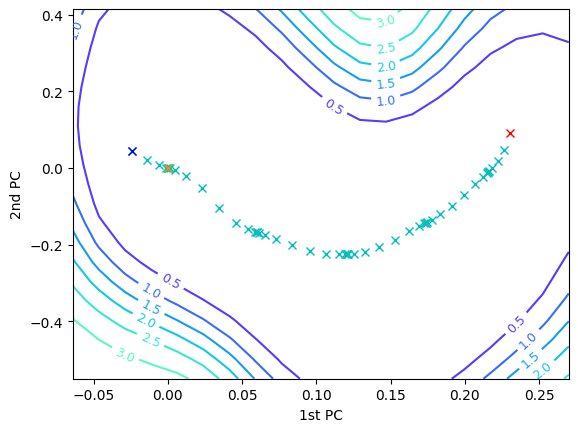

In [20]:
fig, ax = plt.subplots()

CS = ax.contour(X1, X2, Z, levels=levels, cmap='rainbow', vmin=0, vmax=7.0)
ax.plot(pred_tr_2d[0,0],pred_tr_2d[0,1],'rx')
ax.plot(pred_tr_2d[1:,0],pred_tr_2d[1:,1],'cx')
ax.plot(pred_tr_2d[min_index_tr,0],pred_tr_2d[min_index_tr,1],color='darkorange', marker='x')
ax.plot(pred_tr_2d[-1,0],pred_tr_2d[-1,1],'bx')
ax.clabel(CS, fontsize=9)
ax.set(xlabel='1st PC', ylabel='2nd PC')
plt.savefig('imgs/'+save_fig_name+'.png', bbox_inches='tight')
plt.show()

3.45 0.0 [0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ]


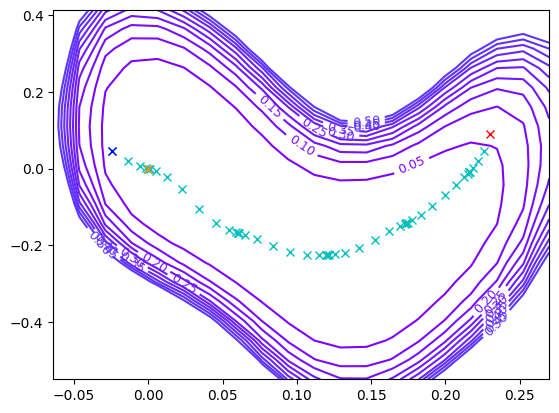

In [21]:
MAX = np.ceil(df_mesh['train_loss'].max()*100)/100
MIN = np.floor(df_mesh['train_loss'].min()*100)/100
levels = np.arange(0.05, 0.55, 0.05)
print(MAX, MIN, levels)

fig, ax = plt.subplots()
CS = ax.contour(X1, X2, Z, levels=levels, cmap='rainbow', vmin=0, vmax=7.0)
ax.plot(pred_tr_2d[0,0],pred_tr_2d[0,1],'rx')
ax.plot(pred_tr_2d[1:,0],pred_tr_2d[1:,1],'cx')
ax.plot(pred_tr_2d[min_index_tr,0],pred_tr_2d[min_index_tr,1],color='darkorange', marker='x')
ax.plot(pred_tr_2d[-1,0],pred_tr_2d[-1,1],'bx')
ax.clabel(CS, fontsize=9)
plt.savefig('imgs/'+save_fig_name+'_enlarge.png', bbox_inches='tight')
plt.show()

3.45 0.0 [0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5.  5.5 6.  6.5]


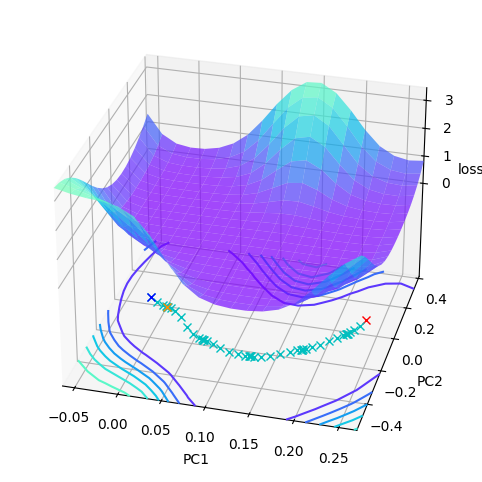

In [22]:
MAX = np.ceil(df_mesh['train_loss'].max()*100)/100
MIN = np.floor(df_mesh['train_loss'].min()*100)/100
levels = np.arange(0.5, 7.0, 0.5)
print(MAX, MIN, levels)

offset = -3.5
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(X1, X2, Z, cmap='rainbow', vmin=0, vmax=7.0, alpha=0.7)
CS = ax.contour(X1, X2, Z, offset=offset, levels=levels, cmap='rainbow', vmin=0, vmax=7.0)
#clabel_text_list = CS.clabel()
#for _, tmp in enumerate(CS.clabel()):
#    val = float(tmp.get_text())
#    ax.text(tmp._x, tmp._y, offset, str(val), fontsize=9, color=tmp.get_color())

ax.plot(pred_tr_2d[0,0],pred_tr_2d[0,1],'rx',zs=offset)
ax.plot(pred_tr_2d[1:,0],pred_tr_2d[1:,1],'cx',zs=offset)
ax.plot(pred_tr_2d[min_index_tr,0],pred_tr_2d[min_index_tr,1],color='darkorange', marker='x',zs=offset)
ax.plot(pred_tr_2d[-1,0],pred_tr_2d[-1,1],'bx',zs=offset)
ax.set(xlim=(X1.flatten().min(), X1.flatten().max()), 
       ylim=(X2.flatten().min(), X2.flatten().max()), 
       zlim=(offset,Z.flatten().max()), xlabel='PC1', ylabel='PC2', zlabel='loss')
ax.set_zticks(np.arange(0, MAX, 1))
#fig.colorbar(surf)
ax.view_init(elev=30, azim=-75)
plt.savefig('imgs_3d/'+save_fig_name+'_3d.png', bbox_inches='tight')
plt.show()